#  add kg_class (ID in excel) to location_ID.nc and save it to kg_class_location_ID.nc

In [6]:
import xarray as xr
import numpy as np

# Load the datasets
kg_ds = xr.open_dataset('/home/jguo/other_projects/1991_2020/koppen_geiger_0p5.nc')
loc_ds = xr.open_dataset('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.05/research_results/summary/location_IDs.nc')

# Adjust the longitude range of kg_ds to match loc_ds (0 to 360)
kg_ds['lon'] = (kg_ds['lon'] + 360) % 360
kg_ds = kg_ds.sortby('lon')

# Reindex kg_ds to match the coordinates of loc_ds
kg_reindexed = kg_ds.reindex(lat=loc_ds.lat, lon=loc_ds.lon, method='nearest', fill_value=kg_ds.kg_class.attrs.get('_FillValue', np.nan))

# Merge kg_reindexed into loc_ds
merged_ds = loc_ds.assign(kg_class=kg_reindexed.kg_class)

# Save the merged dataset to a new netCDF file
output_path = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.05/research_results/summary/kg_class_location_ID.nc'
# merged_ds.to_netcdf(output_path)

# Plot to verify

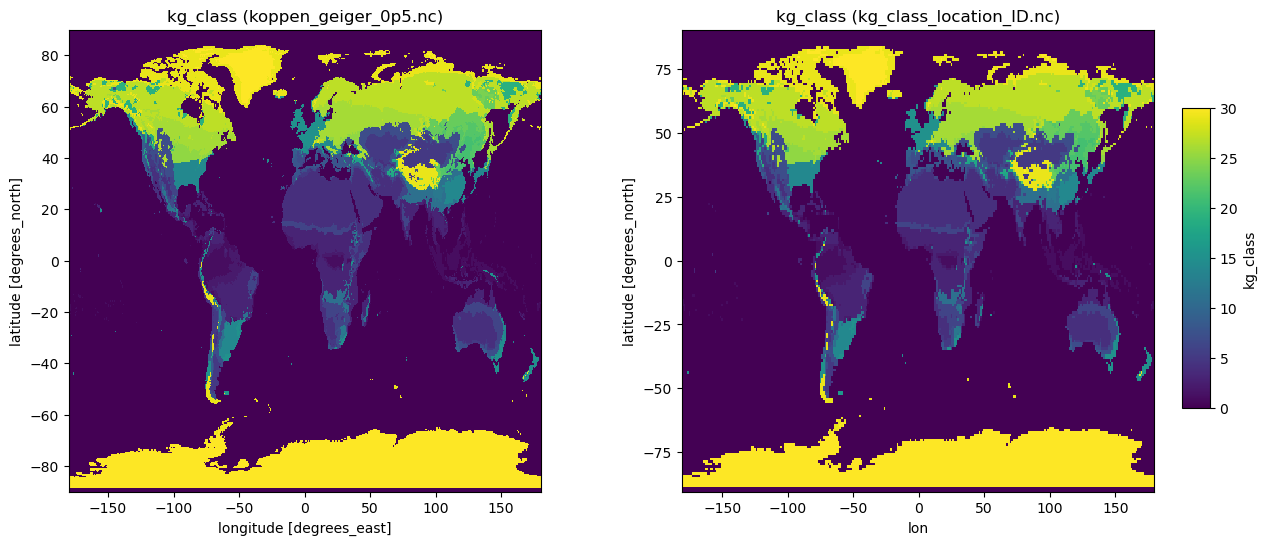

In [7]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the datasets
kg_ds = xr.open_dataset('/home/jguo/other_projects/1991_2020/koppen_geiger_0p5.nc')
merged_ds = xr.open_dataset('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.05/research_results/summary/kg_class_location_ID.nc')

# Adjust the longitude range of merged_ds to match kg_ds
merged_ds = merged_ds.assign_coords(lon=(((merged_ds.lon + 180) % 360) - 180)).sortby('lon')

# Create a figure with two subplots and a colorbar axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Add a new axis for the colorbar

# Plot kg_class from koppen_geiger_0p5.nc
im1 = kg_ds.kg_class.plot(ax=ax1, cmap='viridis', add_colorbar=False)
ax1.set_title('kg_class (koppen_geiger_0p5.nc)')

# Plot kg_class from kg_class_location_ID.nc
im2 = merged_ds.kg_class.plot(ax=ax2, cmap='viridis', add_colorbar=False)
ax2.set_title('kg_class (kg_class_location_ID.nc)')

# Add a colorbar to the right of the second subplot
fig.colorbar(im2, cax=cbar_ax, label='kg_class')

# Adjust the layout and display the plot
plt.subplots_adjust(wspace=0.3)
plt.show()

# Generate text based KG location info

In [8]:
import xarray as xr
import pandas as pd

# Load the kg_class_location_ID.nc file into an xarray Dataset
ds = xr.open_dataset('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.05/research_results/summary/kg_class_location_ID.nc')

# Convert the Dataset to a DataFrame
df = ds.to_dataframe()

# Reset the index to convert multi-index to columns
df = df.reset_index()

# Load the Excel file into a pandas DataFrame
kg_legend = pd.read_excel('/home/jguo/research/hw_global/Data/KoppenGeigerLegend.xlsx', engine='openpyxl')

# Join the kg_class DataFrame with the Excel DataFrame based on the ID column
merged_df = df.merge(kg_legend[['ID', 'KGClass', 'KGMajorClass']], left_on='kg_class', right_on='ID', how='left')

# Drop the redundant 'ID' column
merged_df = merged_df.drop('ID', axis=1)

# Save the resulting DataFrame as a Feather file
output_path = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.05/research_results/summary/kg_category_location_ID.feather'
# merged_df.to_feather(output_path)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def normalize_longitude(lon):
    return ((lon + 180) % 360) - 180

# Function to draw the map with categories
def draw_map_subplot(data, title):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)  # Adjust figure size and DPI for high resolution
    if data.empty:
        print(f"No data available for {title}. Skipping plot.")
        ax.set_title(title + " - No Data Available")
        return

    m = Basemap(projection='cyl', lon_0=0, ax=ax,
                fix_aspect=False,
                llcrnrlat=-44.94133,urcrnrlat=65.12386,)
    m.drawcoastlines(color = '0.15',linewidth=0.5,zorder=3)
    m.drawcountries(linewidth=0.1)
    m.fillcontinents(color='white',lake_color='lightcyan')
    m.drawmapboundary(fill_color='lightcyan')
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=10)

    normalized_lons = normalize_longitude(data['lon'].values)
    x, y = m(normalized_lons, data['lat'].values)

    # Dynamically set color map limits based on the data
    vmin, vmax = data['kg_class'].min(), data['kg_class'].max()
    sc = m.scatter(x, y, c=data['kg_class'], cmap='coolwarm', marker='o', edgecolor='none', s=10, alpha=0.75, vmin=vmin, vmax=vmax)
    plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
    ax.set_title(title)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55296 entries, 0 to 55295
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lon           55296 non-null  float32
 1   lat           55296 non-null  float32
 2   location_ID   55296 non-null  int64  
 3   kg_class      55296 non-null  float32
 4   KGClass       19530 non-null  object 
 5   KGMajorClass  19530 non-null  object 
dtypes: float32(3), int64(1), object(2)
memory usage: 1.9+ MB


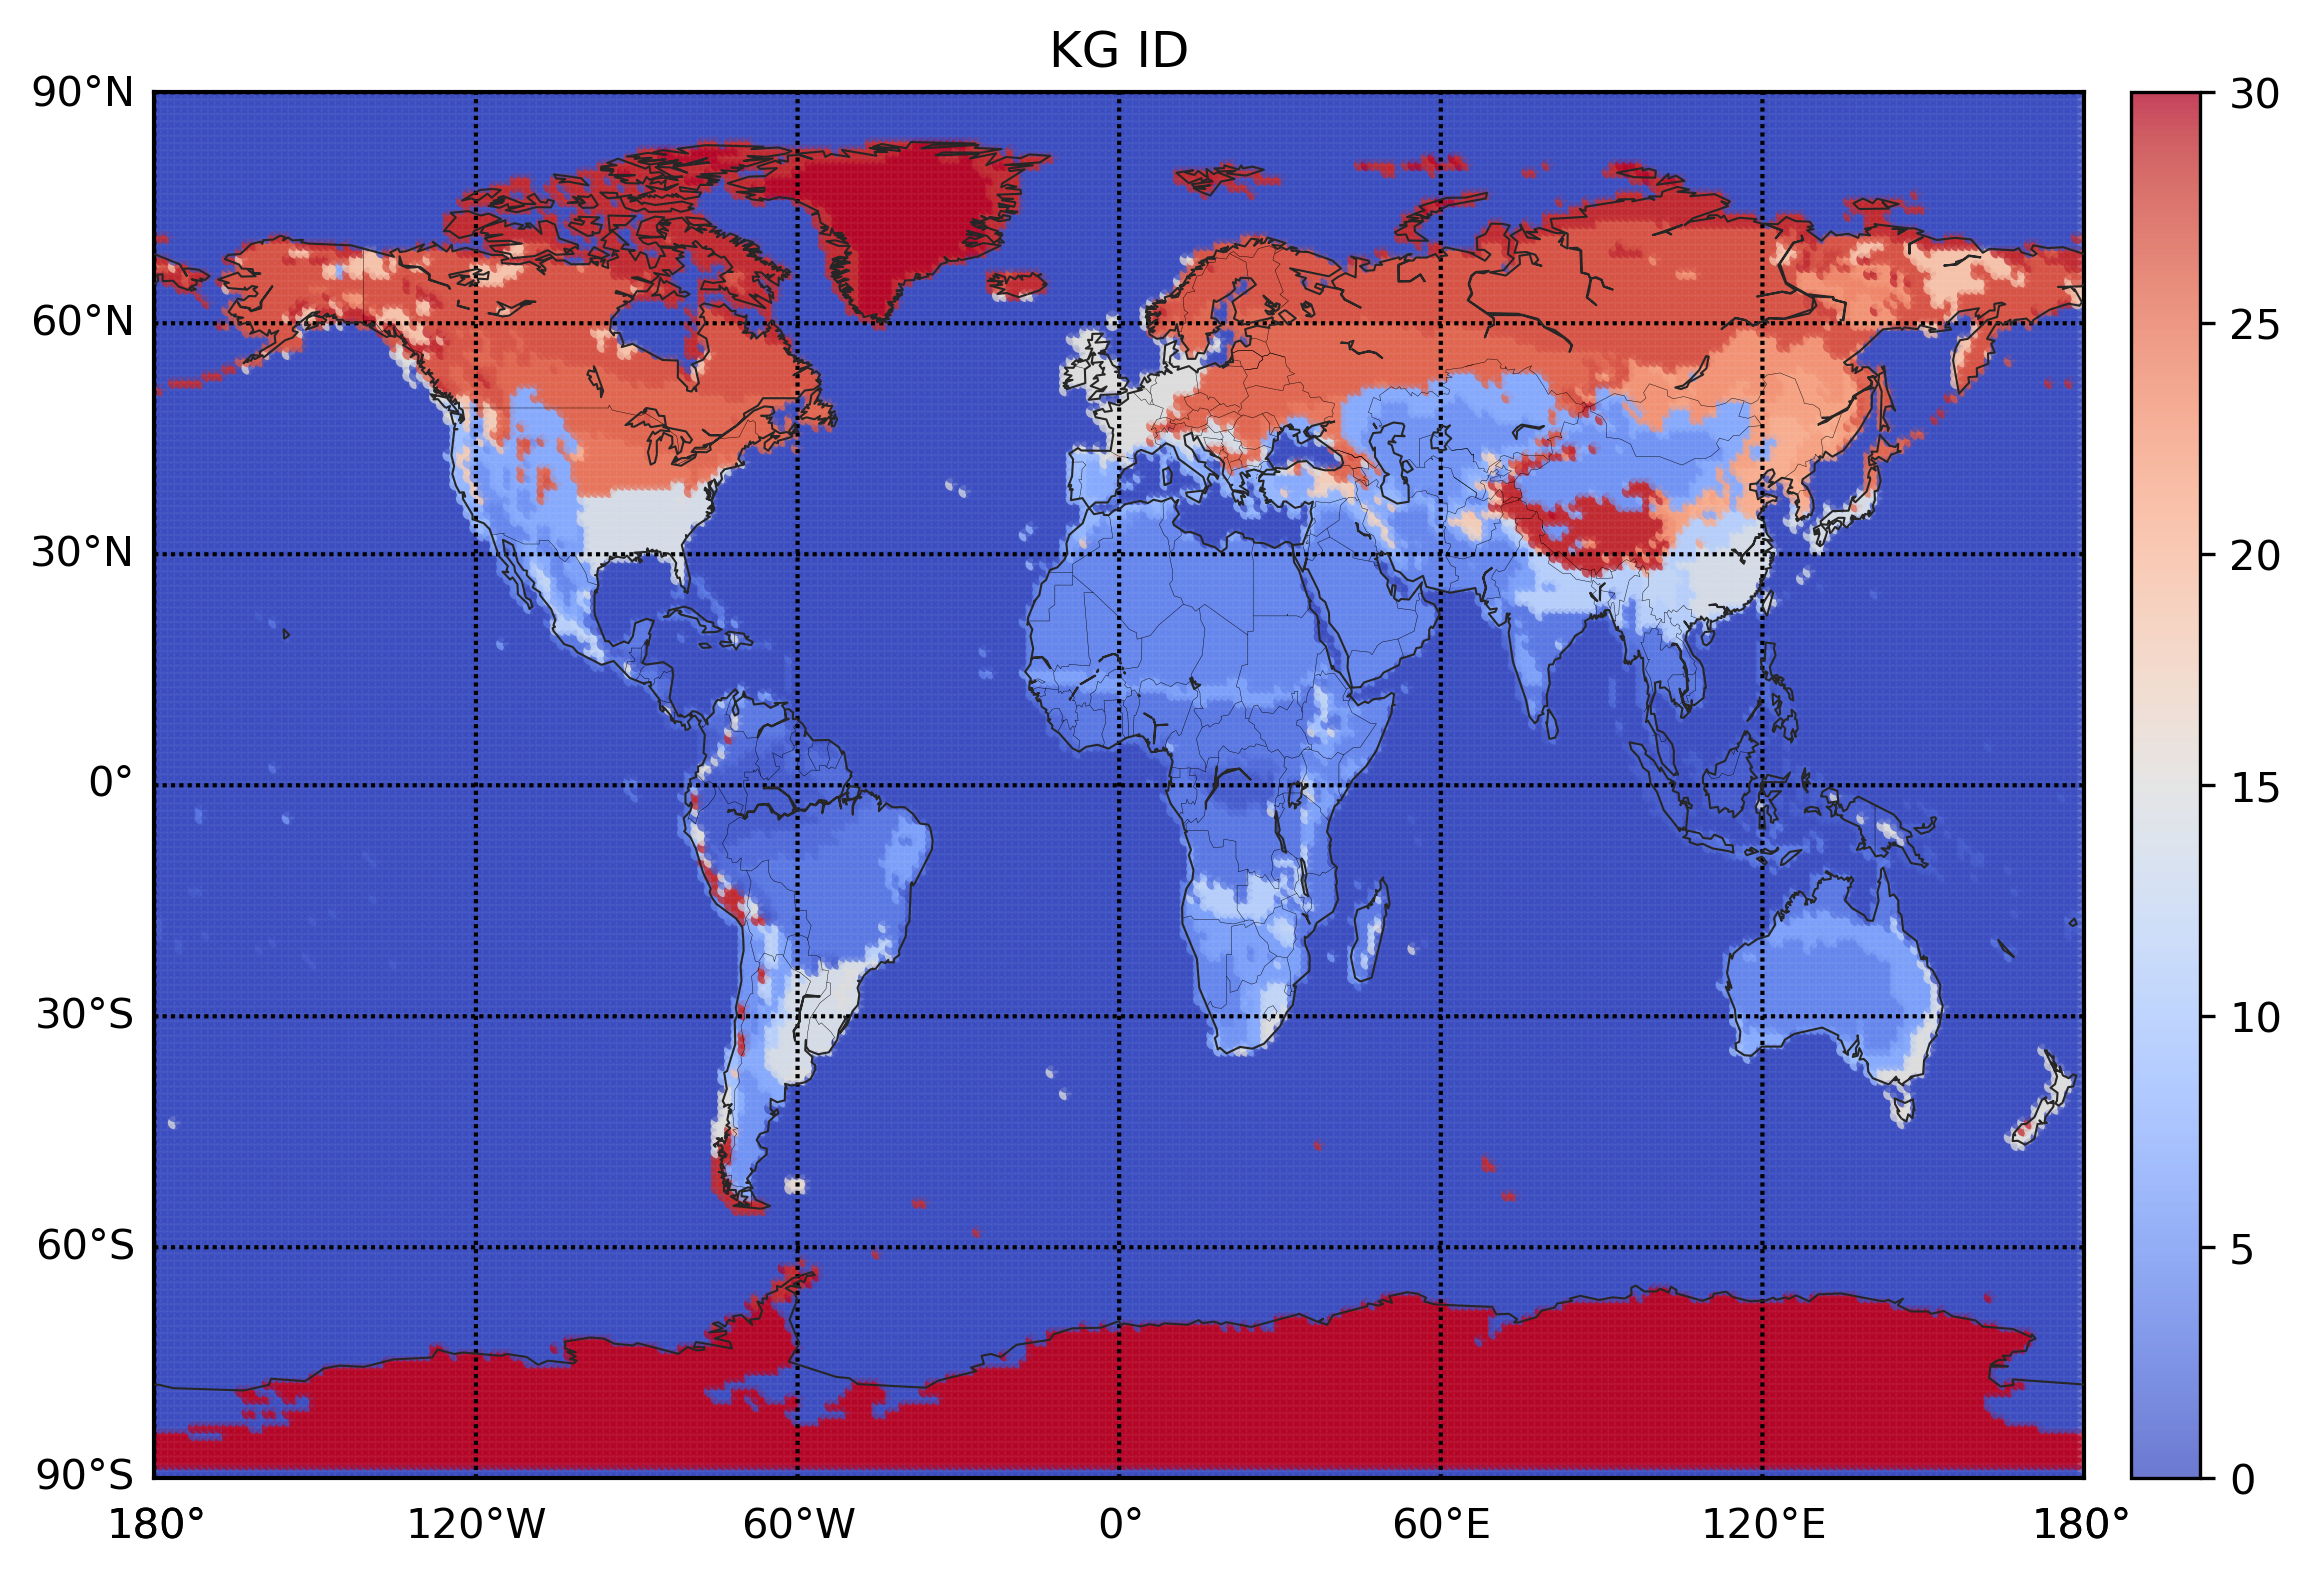

In [10]:
# Read the Feather file into a DataFrame
df = pd.read_feather('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.05/research_results/summary/kg_category_location_ID.feather')
df.info()
draw_map_subplot(df, 'KG ID')

In [11]:
#find rows in df where KGMajorClass is nan
nan_rows = df[df['KGMajorClass'].isna()]
#save nan_rows to a feather file
# nan_rows.to_feather('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.05/research_results/summary/nan_rows.feather')
nan_rows

,lon,lat,location_ID,kg_class,KGClass,KGMajorClass
0,0.00,-90.000000,0,0.0,None,None
1,0.00,-89.057594,288,0.0,None,None
21,0.00,-70.209427,6048,0.0,None,None
22,0.00,-69.267014,6336,0.0,None,None
23,0.00,-68.324608,6624,0.0,None,None
...,...,...,...,...,...,...
55291,358.75,86.230370,54143,0.0,None,None
55292,358.75,87.172775,54431,0.0,None,None
55293,358.75,88.115181,54719,0.0,None,None
55294,358.75,89.057594,55007,0.0,None,None
